<a href="https://colab.research.google.com/github/hyunseo-hy/FinEng/blob/main/Index_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import pandas as pd
from urllib.request import urlopen, Request
import json
from pprint import pprint
from datetime import date
import bs4
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [100]:
def date_format(d):
  d = str(d).replace('-','.')
  yyyy = int(d.split('.')[0])
  mm = int(d.split('.')[1])
  dd = int(d.split('.')[2])

  this_date = dt.date(yyyy,mm,dd)
  return this_date

In [101]:
def read_json(d, symbol, page=1):
  url = "https://finance.naver.com/world/worldDayListJson.naver?symbol=" + symbol + "&fdtc=0&page=" + str(page)
  req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

  try:
      response = urlopen(req)
      raw_bytes = response.read()
      decoded_str = raw_bytes.decode('euc-kr').strip()
      data = json.loads(decoded_str)
  except Exception as e:
      print(f"에러 발생: {e}")

  for n in range(len(data)):
    date_var = pd.to_datetime(data[n]["xymd"]).date()
    price = float(data[n]["clos"])
    d[date_var] = price

  if len(data) == 10:
    page+=1
    if page >= 5: # Due to time delay, limit to the page 4
      return(d)
    read_json(d, symbol, page)
  if len(data) == 9 and str(data[0]["xymd"]) == str(date.today()):
    page+=1
    read_json(d, symbol, page)

  return(d)

In [102]:
def date_format(d=""):
  if d != "":
    this_date = pd.to_datetime(d).date()
  else:
    this_date = pd.Timestamp.today().date()
  return(this_date)

In [108]:
def idx_global(d, symbol, start_date="", end_date=date.today(), page=1):
  end_date = date_format(end_date)
  if start_date == "":
    start_date = end_date - pd.DateOffset(months=1) # if user doesn't assign a start date then, assign as a month before the end date (default setting)
  start_date = date_format(start_date)

  url = f"https://finance.naver.com/world/worldDayListJson.naver?symbol={symbol}&fdtc=0&page={page}"
  req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  try:
    response = urlopen(req)
    raw_bytes = response.read()
    decoded_str = raw_bytes.decode('euc-kr').strip()
    data = json.loads(decoded_str)
  except Exception as e:
    print(f"에러 발생: {e}")

  if len(data) > 0:

    for n in range(len(data)):
      date = pd.to_datetime(data[n]["xymd"]).date()

      if date <= end_date and date >= start_date:
        d[date] = price = float(data[n]["clos"])

  if len(data) == 9 and str(data[0]["xymd"]) == str(date.today()):
    page+=1
    if date <= end_date and date >= start_date:
      idx_global(d,symbol, start_date, end_date, page)

  if len(data) == 10:
    page+=1
    if date <= end_date and date >= start_date:
      idx_global(d,symbol, start_date, end_date, page)

  return(d)

In [139]:
def his_index_naver(index_cd, start_date = "", end_date="", page_n=1, last_page=0):
  if start_date:
    start_date = date_format(start_date)
  else:
    start_date = dt.date.today()

  if end_date:
    end_date = date_format(end_date)
  else:
    end_date = dt.date.today()

  naver_index = "https://finance.naver.com/sise/sise_index_day.naver?code=" + index_cd + "&page=" + str(page_n)
  source = urlopen(naver_index).read()
  source = bs4.BeautifulSoup(source,"lxml")
  dates = source.find_all("td", class_="date")
  prices = source.find_all("td", class_= "number_1")

  for n in range(len(dates)):
    if dates[n].text.split('.')[0].isdigit():
      #Dates Process
      this_date = dates[n].text
      this_date = date_format(this_date)
      if this_date <= end_date and this_date >= start_date:
        #Prices Process
        this_close = prices[n*4].text
        this_close = this_close.replace(',','')
        this_close = float(this_close)
        #Save the dictionary
        historical_prices[this_date] = this_close
      elif this_date < start_date:
        return historical_prices

  if last_page == 0:
    last_page = source.find("td", class_="pgRR").find("a")["href"]
    last_page = last_page.split("&")[1]
    last_page = last_page.split("=")[1]
    last_page = int(last_page)

  if page_n < last_page:
    page_n = page_n+1
    his_index_naver(index_cd, start_date, end_date, page_n, last_page)
  return historical_prices

In [140]:
# his_index_naver(index_cd, start_date = "", end_date="", page_n=1, last_page=0)
index_cd = "KPI200"
historical_prices = dict()
kospi200 = his_index_naver(index_cd, "2015-1-1", "2026-1-22")

# idx_global(d, symbol, start_date="", end_date=date.today(), page=1)
index_cd = "SPI@SPX"
historical_prices = dict()
sp500 = idx_global(historical_prices, index_cd, "2015-1-1", "2026-1-22")
print(sp500)
# merge dictinary into a matrix form
tmp = {"S&P500": sp500, "KOSPI200": kospi200}
df = pd.DataFrame(tmp).sort_index(ascending=False)
# interporation for the NaN blanks
df = df.fillna(method="ffill")
if df.isnull().values.any():
    df = df.fillna(method="bfill")
print(df.tail())

KeyboardInterrupt: 

/tmp/ipython-input-3709365965.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0)
/tmp/ipython-input-3709365965.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0)


S&P500      2058.20
KOSPI200     244.79
Name: 2015-01-02, dtype: float64


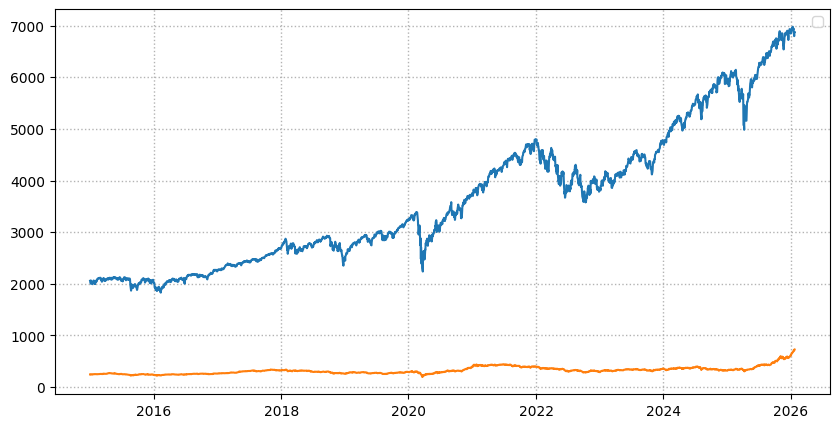

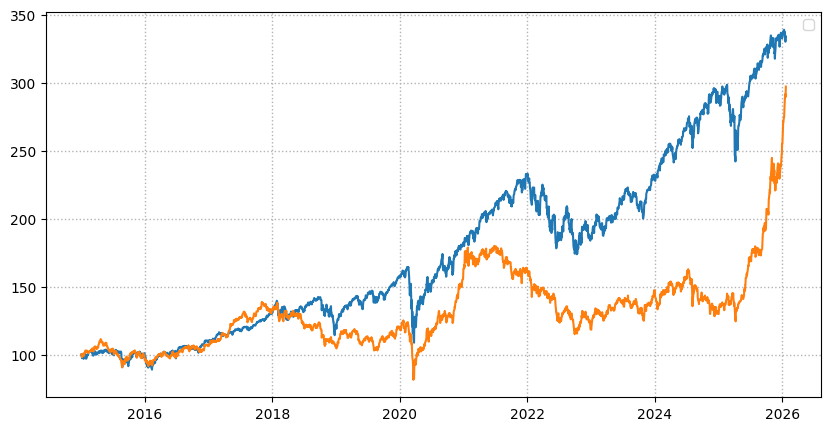

In [149]:
%matplotlib inline
# value plots
plt.figure(figsize=(10,5))
plt.plot(df['S&P500'])
plt.plot(df["KOSPI200"])
plt.legend(loc=0)
plt.grid(True, color="0.7", linestyle=":", linewidth=1)

# ratio plots
print(df.iloc[len(df)-1])
plt.figure(figsize=(10,5))
plt.plot(df['S&P500']/df['S&P500'].iloc[len(df)-1]*100)
plt.plot(df["KOSPI200"]/df['KOSPI200'].iloc[len(df)-1]*100)
plt.legend(loc=0)
plt.grid(True, color="0.7", linestyle=":", linewidth=1)

/tmp/ipython-input-604468049.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0)


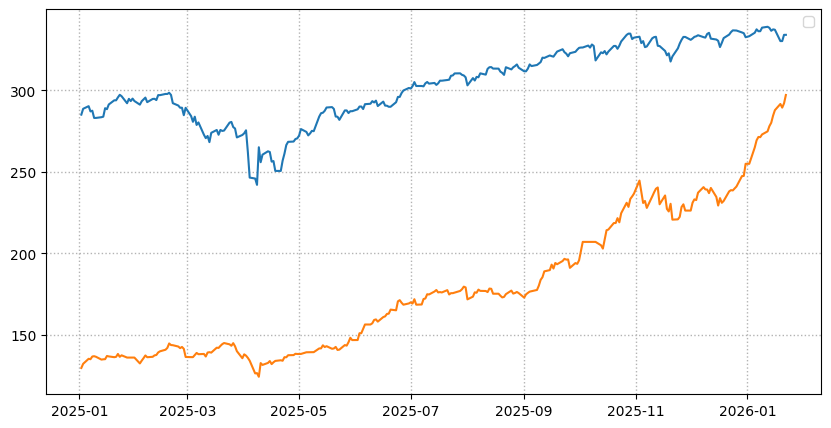

In [158]:
# data from 2025 to now
df_ratio_2025_to_now = df.loc[:dt.date(2025,1,1)]/df.iloc[len(df)-1]*100
reduced_df = df_ratio_2025_to_now

plt.figure(figsize=(10,5))
plt.plot(reduced_df)
plt.legend(loc=0)
plt.grid(True, color="0.7", linestyle=":", linewidth=1)

Text(0, 0.5, 'KOSPI200')

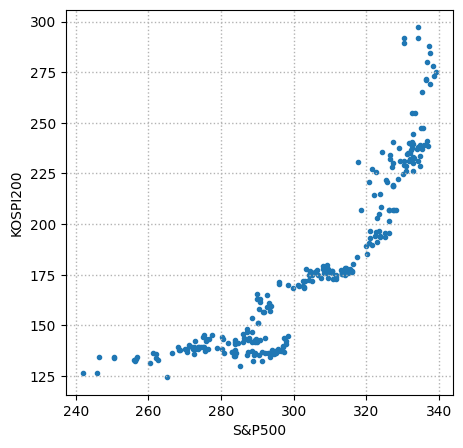

In [163]:
# scatter plot b/w KOSPI200 and S&P500
plt.figure(figsize=(5,5))
plt.scatter(reduced_df['S&P500'], reduced_df["KOSPI200"], marker = ".")
plt.grid(True, color="0.7", linestyle=":", linewidth=1)
plt.xlabel("S&P500")
plt.ylabel("KOSPI200")

{'Slope': np.float64(1.6565212562834166), 'Intercept': np.float64(-324.1941735435654), 'R^2': 0.7929444012408976}


Text(0, 0.5, 'KOSPI200')

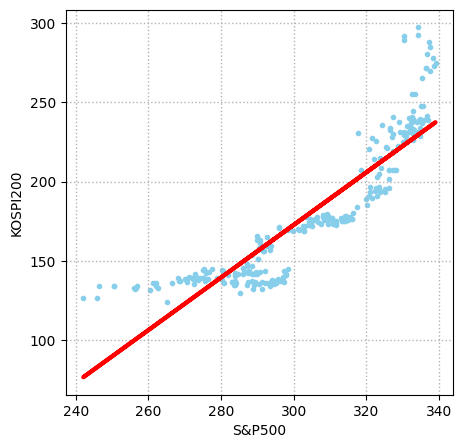

In [176]:
# Linear Regression
x = reduced_df['S&P500']
y = reduced_df["KOSPI200"]

independent_var = np.array(x).reshape(-1,1)
dependent_var = np.array(y).reshape(-1,1)

regr = LinearRegression()
regr.fit(independent_var, dependent_var)

result = {"Slope" : regr.coef_[0,0], "Intercept": regr.intercept_[0], "R^2" : regr.score(independent_var,dependent_Var)}
print(result)

# Plot a trend line
plt.figure(figsize=(5,5))
plt.scatter(independent_var, dependent_var, marker = ".", color = "skyblue")
plt.plot(independent_var, regr.predict(independent_var,), color="r", linewidth=3)
plt.grid(True, color="0.7", linestyle=":", linewidth=1)
plt.xlabel("S&P500")
plt.ylabel("KOSPI200")